In [ ]:
# from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path

import svg.path as spath
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from pynest.utils import create_rectangle, convex_hull_polygon

In [ ]:
class ViewBox:

    def __init__(self, viewbox:str):
        viewbox_parts = viewbox.split(" ")
        viewbox_parts = [float(p) for p in viewbox_parts]
        self.xmin = viewbox_parts[0]
        self.ymin = viewbox_parts[1]
        self.width = viewbox_parts[2]
        self.height = viewbox_parts[3]


In [ ]:
class Segment:
    def __init__(self, x0, y0, x1, y1):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1

    def start(self):
        return (self.x0, self.y0,)

    def end(self):
        return (self.x1, self.y1, )

    def x_angle(self) -> float:
        deltaX = self.x1 - self.x0
        deltaY = self.y1 - self.y0

        return np.arctan(deltaY/deltaX)

    def rotate(self,theta:float, center =(0,0,)):
        P = np.array([[self.x0, self.x1], 
                      [self.y0, self.y1]])
        C = np.array([[center[0], center[0]], 
                      [center[1], center[1]]])
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

        P = np.matmul(R, P - C) + C

        return Segment(P[0,0], P[1,0], P[0,1], P[1,1])

    def plot(self):
        points = np.array([self.start(), self.end()])
        plt.plot(points[:,0], points[:,1], 'k-', lw=1)

In [39]:

class Polygon:
    
    def __init__(self):
        self.segments = []

    def add_segment(self, segment:Segment):
        self.segments.append(segment)

    
    def to_points(self) -> tp.List[tp.Tuple[float, float]]:
        points = []
        for segment in self.segments:
            points.append(segment.start())
            points.append(segment.end())

        return points

    def plot(self) -> None:
        for segment in self.segments:
            plt.plot(np.array([segment.x0, segment.x1]), np.array([segment.y0, segment.y1]), 'k-')

    def centroid(self) -> tp.Tuple[float, float]:
        points = np.array(self.to_points())
        x_center = np.mean(points[:, 0])
        y_center = np.mean(points[:, 1])
        
        return (x_center, y_center,)

    def rotate(self, theta, center: tp.Tuple[float, float] = None):

        if center is None:
            center = self.centroid()
            
        points = np.array(self.to_points())

        P = np.array([points[:, 0], points[:, 1]])
        C = np.array([[center[0] for _ in range(0, P.shape[1])],
                      [center[1] for _ in range(0, P.shape[1])]])
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

        P = np.matmul(R, P - C) + C 

        # Create new Polygon
        pol = Polygon()
        x0 = P[0,0]
        y0 = P[1,0]

        for i in range(1, P.shape[1]):
            x1 = P[0, i]
            y1 = P[1, i]
            pol.add_segment(Segment(x0, y0, x1, y1))

            x0 = x1
            y0 = y1

        return pol

In [40]:
class Piece(Polygon):
    
    def __init__(self):
        self.segments: tp.List[Segment] = []

    def _get_scale(self, width:float, viewbox:ViewBox):
        scale_width = viewbox.width - viewbox.xmin
        return width/scale_width

    def add_segments_from_path(self, d:str, width: float, viewbox:ViewBox):
        # Convert to path object
        path = spath.parse_path(d)
        segments = path._segments
        n_segments = len(segments)

        scale = self._get_scale(width, viewbox)

        # Iterate in path and map segments
        for i in range(1, n_segments):
            segment = segments[i]

            start = segment.start
            end = segment.end

            x0 = start.real * scale
            y0 = start.imag * scale
            x1 = end.real * scale
            y1 = end.imag * scale

            self.segments.append(Segment(x0,y0,x1,y1))

In [41]:
class BoundingRect:
    
    def __init__(self, piece:Piece):
        super().__init__()
        self.piece: Piece = piece
        self.bounding_rect: Polygon = None

    def set_min_bounding_rect(self, rotate_piece:bool=True):
        points = np.array(self.piece.to_points())
        convex_hull = convex_hull_polygon(points)

        min_area = np.Inf
        # Rotate the convex hull such that the current
        # segment is parallel to the x-axis.
        for segment in convex_hull.segments:
            theta = segment.x_angle()

            convex_hull_rotated = convex_hull.rotate(-theta, (0,0,))
            convex_hull_points = np.array(convex_hull_rotated.to_points())

            # Calculate bouding rectangle
            xs = convex_hull_points[:, 0]
            ys = convex_hull_points[:, 1]

            xmin = np.min(xs)
            xmax = np.max(xs)
            ymin = np.min(ys)
            ymax = np.max(ys)

            area = (ymax - ymin) * (xmax - xmin)
            
            if area < min_area:
                self.theta = theta
                self.bounding_rect = create_rectangle(xmin, xmax, ymin, ymax)
                min_area = area

        if rotate_piece:
            self.piece = self.piece.rotate(-self.theta, (0,0,))
    
        def rotate(theta:float, center:tp.Tuple[float, float] = None):
            self.piece = self.piece.rotate(theta, center)
            self.bounding_rect = self.bounding_rect.rotate(theta, center)
            self.theta = self.theta + theta

            return self



In [42]:
viewbox = ViewBox("0 0 3162.3857 1629.1533")
width=836.71454

In [43]:
piece = Piece()
d="m 1075.7137,3137.1631 56.24,-59.0144"
piece.add_segments_from_path(d, width, viewbox)

d = "m 1019.7528,3078.145 55.9609,59.0181"
piece.add_segments_from_path(d, width, viewbox)

d = "m 1137.9326,3050.57 -20.4177,20.0446 -41.7993,8.3604 -41.6655,-8.3554 -20.3171,-20.0444 6.0198,27.5698 -3.7236,12.5521 59.6845,46.466 59.932,-46.4531 -3.692,-12.5613 z"
piece.add_segments_from_path(d, width, viewbox)

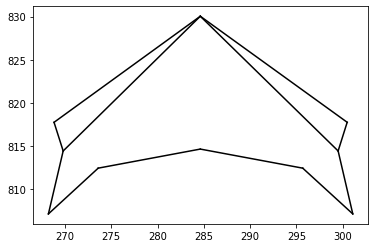

In [44]:
piece.plot()

In [45]:
br = BoundingRect(piece)
br.set_min_bounding_rect()

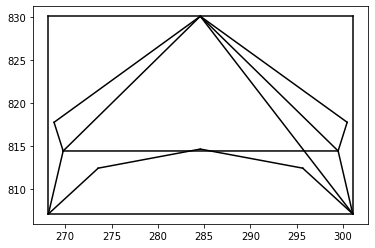

In [46]:
br.bounding_rect.plot()
br.piece.plot()

In [47]:
piece = Piece()
piece.add_segments_from_path("m 1106.123,2878.3077 20.2801,33.341 20.2473,-12.2951 -14.0109,-39.1282 -57.5023,-51.9612 -13.6567,23.3684 -20.5734,22.3248 -35.3948,20.314 73.3538,20.5697 44.9308,18.2593 z", width, viewbox)

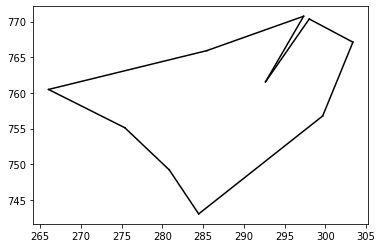

In [56]:
piece.plot()

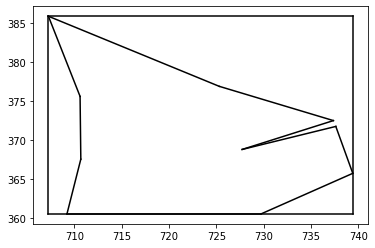

In [61]:
br = BoundingRect(piece)
br.set_min_bounding_rect(rotate_piece=True)
br.piece.plot()
br.bounding_rect.plot()

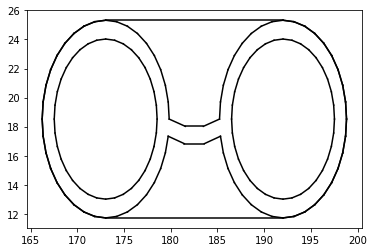

In [69]:
piece = Piece()
d = "m 653.96365,44.29956 -4.46289,0.39063 -4.32618,1.16016 -4.06054,1.89257 -3.66992,2.57032 -3.16797,3.16601 -2.57032,3.66992 -1.89257,4.06055 -1.16016,4.328131 -0.39062,4.462889 0.39062,4.462891 1.16016,4.326169 1.89257,4.06055 2.57032,3.669919 3.16797,3.16797 3.66992,2.57031 4.06054,1.89258 4.32618,1.16015 4.46289,0.39063 4.46289,-0.39063 4.32812,-1.16015 4.0586,-1.89258 3.66992,-2.57031 3.16797,-3.16797 2.57031,-3.669919 1.89258,-4.06055 1.16015,-4.326169 0.39063,-4.462891 6.54297,-1.89258 h 7.28125 l 6.54101,1.89258 0.39063,4.462891 1.16015,4.326169 1.89258,4.06055 2.57031,3.669919 3.16797,3.16797 3.66993,2.57031 4.06054,1.89258 4.32617,1.16015 4.46289,0.39063 4.4629,-0.39063 4.32812,-1.16015 4.06055,-1.89258 3.66992,-2.57031 3.16601,-3.16797 2.57032,-3.669919 1.89453,-4.06055 1.1582,-4.326169 0.39063,-4.462891 -0.39063,-4.462889 -1.1582,-4.328131 -1.89453,-4.06055 -2.57032,-3.66992 -3.16601,-3.16601 -3.66992,-2.57032 -4.06055,-1.89257 -4.32812,-1.16016 -4.4629,-0.39063 -4.46289,0.39063 -4.32617,1.16016 -4.06054,1.89257 -3.66993,2.57032 -3.16797,3.16601 -2.57031,3.66992 -1.89258,4.06055 -1.16015,4.328131 -6.5332,-1.933601 h -8.08008 l -6.53321,1.933601 -1.16015,-4.328131 -1.89258,-4.06055 -2.57031,-3.66992 -3.16797,-3.16601 -3.66992,-2.57032 -4.0586,-1.89257 -4.32812,-1.16016 z m 0,4.88282 3.61523,0.3164 3.50586,0.93946 3.28711,1.5332 2.97266,2.08203 2.5664,2.56641 2.08203,2.9707 1.53321,3.28906 0.93945,3.50586 0.31641,3.61524 -0.31641,3.61523 -0.93945,3.50391 -1.53321,3.28906 -2.08203,2.97266 -2.5664,2.5664 -2.97266,2.080079 -3.28711,1.53516 -3.50586,0.9375 -3.61523,0.3164 -3.61524,-0.3164 -3.5039,-0.9375 -3.28907,-1.53516 -2.97265,-2.080079 -2.56641,-2.5664 -2.08203,-2.97266 -1.5332,-3.28906 -0.93946,-3.50391 -0.3164,-3.61523 0.3164,-3.61524 0.93946,-3.50586 1.5332,-3.28906 2.08203,-2.9707 2.56641,-2.56641 2.97265,-2.08203 3.28907,-1.5332 3.5039,-0.93946 z m 71.76757,0 3.61524,0.3164 3.50586,0.93946 3.28906,1.5332 2.9707,2.08203 2.56641,2.56641 2.08203,2.9707 1.5332,3.28906 0.93946,3.50586 0.3164,3.61524 -0.3164,3.61523 -0.93946,3.50391 -1.5332,3.28906 -2.08203,2.97266 -2.56641,2.5664 -2.9707,2.080079 -3.28906,1.53516 -3.50586,0.9375 -3.61524,0.3164 -3.61523,-0.3164 -3.50391,-0.9375 -3.28906,-1.53516 -2.97265,-2.080079 -2.56641,-2.5664 -2.08008,-2.97266 -1.53516,-3.28906 -0.9375,-3.50391 -0.3164,-3.61523 0.3164,-3.61524 0.9375,-3.50586 1.53516,-3.28906 2.08008,-2.9707 2.56641,-2.56641 2.97265,-2.08203 3.28906,-1.5332 3.50391,-0.93946 z"
piece.add_segments_from_path(d, width, viewbox)

convex_hull = convex_hull_polygon(np.array(piece.to_points()))

convex_hull.plot()
piece.plot()

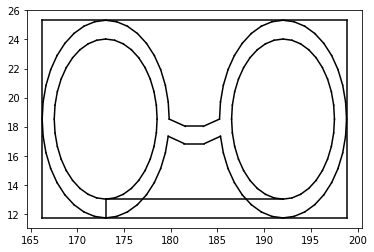

In [70]:
br = BoundingRect(piece)
br.set_min_bounding_rect(rotate_piece=True)
br.piece.plot()
br.bounding_rect.plot()

In [73]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def convex_hull_polygon(points):
    hull = ConvexHull(points)
    chull = Polygon()

    for simplex in hull.simplices:
        x = points[simplex, 0]
        y = points[simplex, 1]

        # print(p0, p1)
        s = Segment(x[0], y[0], x[1], y[1])
        chull.add_segment(s)

    return chull

def create_rectangle(xmin, xmax, ymin, ymax):
    s1 = Segment(xmin, ymin, xmin, ymax)
    s2 = Segment(xmin, ymax, xmax, ymax)
    s3 = Segment(xmax, ymax, xmax, ymin)
    s4 = Segment(xmax, ymin, xmin, ymin)

    ret = Polygon()
    ret.add_segment(s1)
    ret.add_segment(s2)
    ret.add_segment(s3)
    ret.add_segment(s4)

    return ret


points = np.array(piece.to_points())
chull = convex_hull_polygon(points)

# plt.plot(points[:,0], points[:,1], 'o-')


min_ret = {
    'area': np.Inf,
    'theta': None,
    'ret': None,
    'convex_hull': None
}



for segment in chull.segments:
    # segment = chull.segments[2]
    theta = segment.x_angle()

    chull_rotated = chull.rotate(-theta, (0,0,))
    chull_points = np.array(chull_rotated.to_points())

    xs = chull_points[:, 0]
    ys = chull_points[:, 1]

    xmin = np.min(xs)
    xmax = np.max(xs)
    ymin = np.min(ys)
    ymax = np.max(ys)

    ret_area = (ymax - ymin) * (xmax - xmin)
    ret = create_rectangle(xmin, xmax, ymin, ymax)

    # chull_rotated.plot()
    # ret.plot()
    # piece.rotate(-0, (0,0,)).plot()

    if ret_area < min_ret['area']:
        min_ret['theta'] = theta
        min_ret['ret'] = ret
        min_ret['area'] = ret_area
        min_ret['convex_hull'] = chull_rotated

piece.rotate(-min_ret['theta'], (0,0,)).plot()
min_ret['ret'].plot()


# # Rotate to be paralle to x axis
# deltaX = p1[0] - p0[0]
# deltaY = p1[1] - p0[1]
# theta = np.arctan(deltaY/deltaX)



# plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
# chull.plot()



443.21309388395014
493.59504640274275
443.2130938839502
493.59504710427024
493.5939402829206
588.8283250830634
711.282568611454
663.483331669457
493.595161725223
727.6765509856463
711.2825686114543
493.59391955858604
727.6667461849221
711.2825968827251
493.5951613744582
588.8853664592164
711.2822809854797
663.4843890977137
663.4836334593949
588.8865741373248
493.5951739363095
588.637901958403
711.2825686114577
663.6388928249272
588.8286289761946
663.4833316694587
727.6667461849224
711.282568611454
663.4833316694571
588.8869123609085
493.59514956157307
588.6871487720789
711.2825968827301
663.6388928249269
588.8301132911844
663.4840185469229
727.6765509856447
711.2822809854795
